# Import Data

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [134]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_not_combined = pd.read_csv("data/exported/df_not_combined.csv", index_col = 0)

In [135]:
df_not_combined

,ref_pos,ref_kmer,dwell_time,median_value,ref_number,file_name,read_num,modified_status,base_1,base_2,base_3,base_4,base_5,file_type,dwell_time_rolling,median_value_rolling
0,0,AATGG,0.074466,108.450395,ref_0000,modified_rep_1.tsv,#0_0,1.0,A,A,T,G,G,modified,0.033993,108.450395
1,1,ATGGG,0.021499,110.385196,ref_0000,modified_rep_1.tsv,#0_0,0.0,A,T,G,G,G,modified,0.027746,109.417796
2,2,TGGGC,0.033993,108.417694,ref_0000,modified_rep_1.tsv,#0_0,0.0,T,G,G,G,C,modified,0.026592,110.385196
3,3,GGGCT,0.005762,110.508778,ref_0000,modified_rep_1.tsv,#0_0,0.0,G,G,G,C,T,modified,0.021499,110.385196
4,4,GGCTT,0.026592,112.052889,ref_0000,modified_rep_1.tsv,#0_0,0.0,G,G,C,T,T,modified,0.008281,108.417694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225395,191,CGTGC,0.006416,91.601589,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,C,G,T,G,C,unmodified,0.008949,88.949183
225396,192,GTGCC,0.030970,82.289917,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,G,T,G,C,C,unmodified,0.011529,86.714390
225397,193,TGCCT,0.002183,102.220231,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,T,G,C,C,T,unmodified,0.011529,88.949183
225398,194,GCCTG,0.019195,72.236485,ref_0004,unmodified_rep_2.tsv,#4_59,0.0,G,C,C,T,G,unmodified,0.010989,91.151232


In [136]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object"})

In [137]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_combined = df_combined.astype({"ref_number":"object"})

# modeling

In [236]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report, adjusted_rand_score, adjusted_mutual_info_score 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from pprint import pprint

## train test split

In [139]:
final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
train_ref = ["ref_0000","ref_0001","ref_0002"]
test_ref = ["ref_0003"]

In [140]:
seed = 7

### not_combined

In [141]:
X_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
y_finaltest_not_combined = X_finaltest_not_combined.pop("modified_status")
X_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
y_val_not_combined = X_val_not_combined.pop("modified_status")
X_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
y_train_not_combined = X_train_not_combined.pop("modified_status")
X_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]
y_test_not_combined = X_test_not_combined.pop("modified_status")

In [142]:
numeric_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "float"])

In [143]:
numeric_features_not_combined

['dwell_time', 'median_value', 'dwell_time_rolling', 'median_value_rolling']

In [144]:
cat_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "category"])

In [145]:
cat_features_not_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [146]:
imputer1_not_combined = SimpleImputer(strategy="median")
scaler1_not_combined = StandardScaler()
numeric_transformer_not_combined = make_pipeline(imputer1_not_combined,scaler1_not_combined)


imputer2_not_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_not_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_not_combined = make_pipeline(imputer2_not_combined,encoder_not_combined)

preprocessor_not_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined),
        ('cat', cat_transformer_not_combined, cat_features_not_combined)
    ])

### combined

In [147]:
X_finaltest_combined = df_combined[df_combined["ref_number"].isin(final_ref)]
y_finaltest_combined = X_finaltest_combined.pop("modified_status")
X_val_combined = df_combined[df_combined["ref_number"].isin(val_ref)]
y_val_combined = X_val_combined.pop("modified_status")
X_train_combined = df_combined[df_combined["ref_number"].isin(train_ref)]
y_train_combined = X_train_combined.pop("modified_status")
X_test_combined = df_combined[df_combined["ref_number"].isin(test_ref)]
y_test_combined = X_test_combined.pop("modified_status")

In [148]:
numeric_features_combined = list(X_train_combined .columns[X_train_combined .dtypes ==  "float"])

In [149]:
numeric_features_combined

['dwell_time_median',
 'dwell_time_std',
 'dwell_time_min',
 'dwell_time_max',
 'median_value_median',
 'median_value_std',
 'median_value_min',
 'median_value_max']

In [150]:
cat_features_combined = list(X_train_combined.columns[X_train_combined.dtypes ==  "category"])

In [151]:
cat_features_combined
cat_features_combined =[]

In [152]:
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined),
        ('cat', cat_transformer_combined, cat_features_combined)
    ])

## supervised

### baseline

In [153]:
y_pred = np.zeros(len(X_val_not_combined))

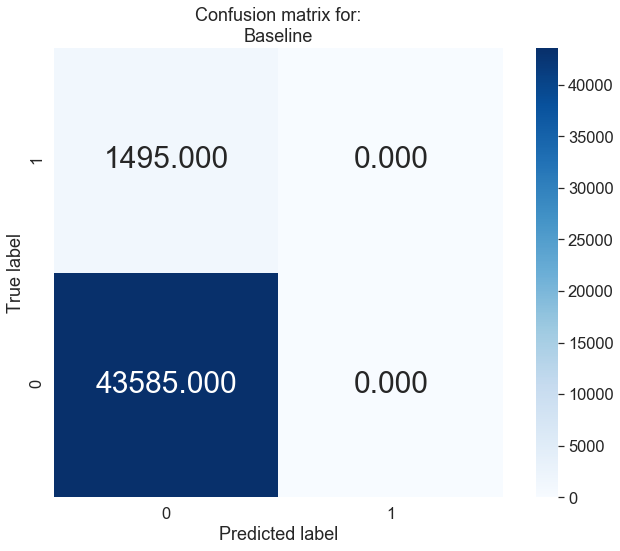

In [154]:
# pretty confusion matrix

cm = confusion_matrix(y_val_not_combined, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
        cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.ylim(0,2)
plt.title('Confusion matrix for:\n{}'.format("Baseline"));

In [155]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     43585
         1.0       0.00      0.00      0.00      1495

    accuracy                           0.97     45080
   macro avg       0.48      0.50      0.49     45080
weighted avg       0.93      0.97      0.95     45080



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### classical ml models

#### model selection

In [ ]:
# prepare models
models = []
models.append(('LR', LogisticRegression(random_state=seed, max_iter = 1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('ADAB', AdaBoostClassifier(random_state=seed)))
models.append(('XGB',  XGBClassifier(random_state=seed)))
models.append(('SVC', SVC(random_state=seed)))
models.append(('GNB', GaussianNB()))

# evaluate each model in turn

scoring = {'precision':'precision',
           'recall': 'recall',
            'f1score':'f1',
          'roc auc':'roc_auc'}

cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
                       for label in np.unique(labels)]

In [253]:
def model_selection (X, Y, models, scoring, cv, preprocessor):
    results = []
    names = []
    val = []
    for name, model in models:
        labels = X.ref_number.values
        
        model_pipe = make_pipeline(preprocessor,model)
        cv_results = cross_validate(model_pipe, X, Y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True)
        results.append(cv_results)
        names.append(name)
        #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        
        #print(msg)
    return results, names

In [254]:
# boxplot algorithm comparison
def model_selection_plot(results, names):
    tests = ["test_precision","test_recall","test_f1score","test_roc auc"]
    plt.figure(figsize = (15,8))
    plt.suptitle('Algorithm Comparison')
    for idx, test in enumerate(tests):
        temp_results = [results[i][test] for i in range(len(results))]
        plt.subplot(1,len(tests),idx+1)
        sns.boxplot(y = temp_results, x = names)
        plt.title(test)
        plt.xticks(rotation = 90)
        plt.ylim(0,1.05)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

In [255]:
results_s, names_s = model_selection(X_finaltest_not_combined, y_finaltest_not_combined, models, scoring,
                                     cv_by_hand, preprocessor_not_combined)

KeyboardInterrupt: 

In [ ]:
model_selection_plot(results_s, names_s)

#### xgb gridsearch

In [202]:
param_grid_xgb = {'xgbclassifier__max_depth':[5,7,10],
                 'xgbclassifier__learning_rate':[0.1,0.2,0.3],
                 'xgbclassifier__n_estimators':[8,9,10],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0.005,0.01,0.02]}

In [203]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [204]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [221]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=4,cv = cv_by_hand)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0.01, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 9}


In [222]:
y_pred=grid_xgb.predict(X_val_not_combined)

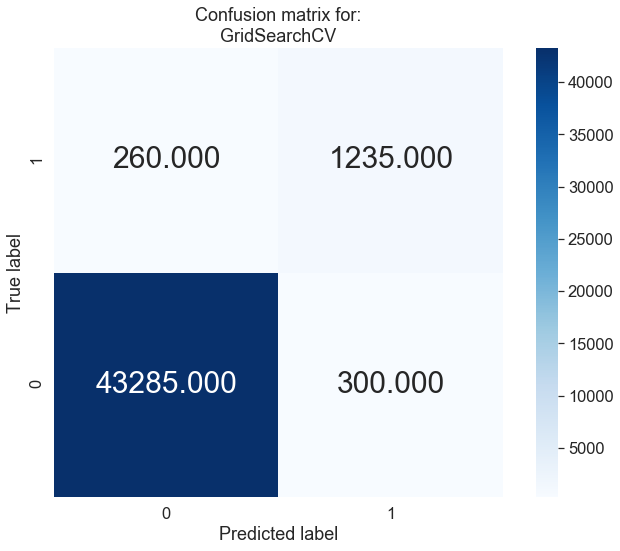

In [223]:
cm = confusion_matrix(y_val_not_combined, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
        cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.ylim(0,2)
plt.title('Confusion matrix for:\n{}'.format(grid_xgb.__class__.__name__));

In [224]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.80      0.83      0.82      1495

    accuracy                           0.99     45080
   macro avg       0.90      0.91      0.90     45080
weighted avg       0.99      0.99      0.99     45080



### Classical ml models with Oversampling

In [273]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smote = SMOTE(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)



In [277]:
def model_selection_os (X, Y, models, scoring, cv):
    results = []
    names = []
    val = []
    for name, model in models:
        labels = X.ref_number.values
        
        model_pipe = Pipeline([("transformer",preprocessor_not_combined),("smt",smote),(name,model)])
        cv_results = cross_validate(model_pipe, X, Y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True)
        results.append(cv_results)
        names.append(name)
        #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        
        #print(msg)
    return results, names

#### model selection

In [278]:
results_os, names_os = model_selection_os(X_finaltest_not_combined, y_finaltest_not_combined, models, scoring,
                                     cv_by_hand)

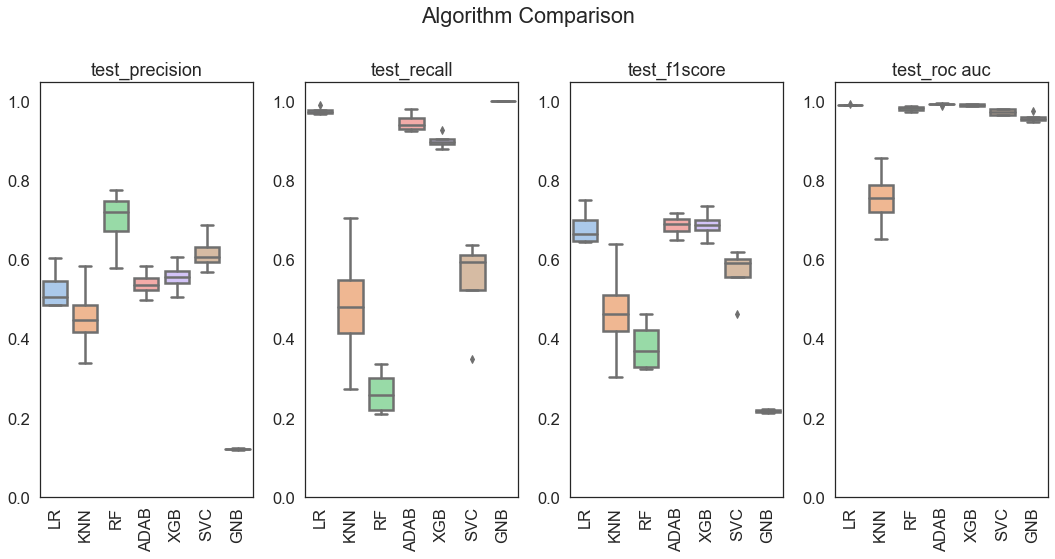

In [279]:
model_selection_plot(results_os, names_os)

#### xgb gridsearch

In [297]:
param_grid_xgb = {'xgbclassifier__max_depth':[5,7,10],
                 'xgbclassifier__learning_rate':[0.05,0.1,0.2],
                 'xgbclassifier__n_estimators':[10,20,50,100],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0,0.005,0.01,0.02]}

In [298]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_not_combined),("smt",smote),("xgbclassifier",xgb_clf)])

In [299]:
labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

In [301]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 20}


In [302]:
y_pred=grid_xgb.predict(X_val_not_combined)

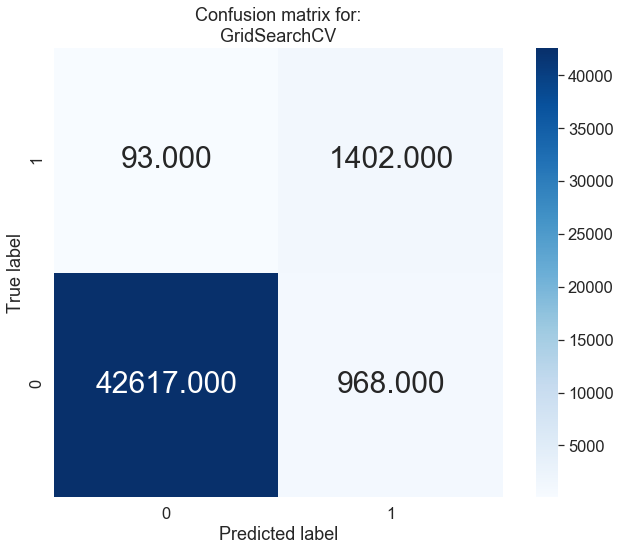

In [303]:
cm = confusion_matrix(y_val_not_combined, y_pred)
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
        cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.ylim(0,2)
plt.title('Confusion matrix for:\n{}'.format(grid_xgb.__class__.__name__));

In [304]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     43585
         1.0       0.59      0.94      0.73      1495

    accuracy                           0.98     45080
   macro avg       0.79      0.96      0.86     45080
weighted avg       0.98      0.98      0.98     45080



## unsupervised

### TSNE

In [209]:
from sklearn.manifold import TSNE

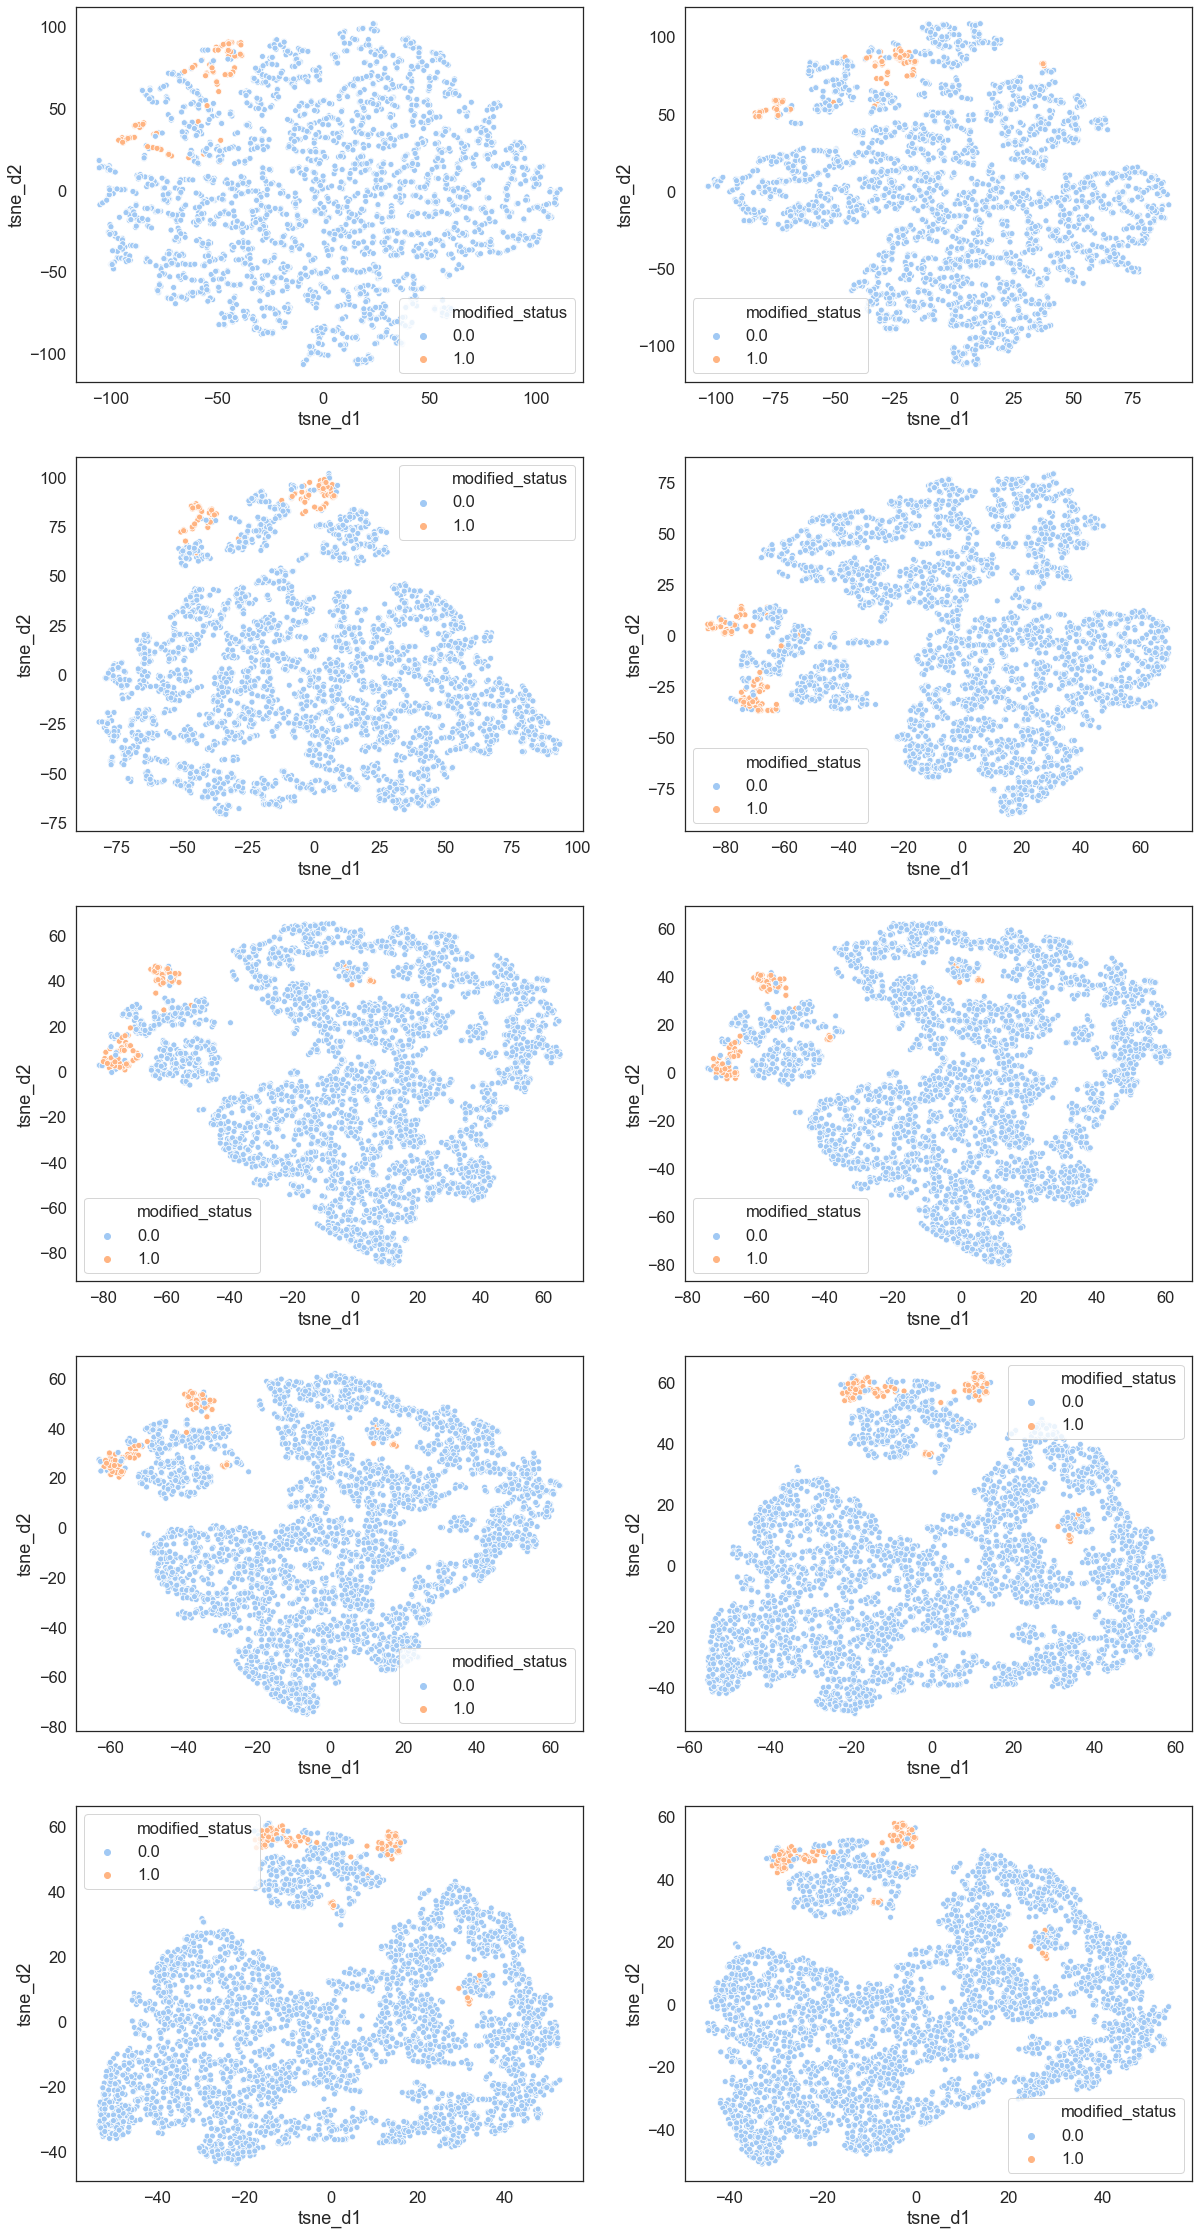

In [210]:

plt.figure(figsize = (20,40))

for perplexity in range (5,51,5):
    tsne = TSNE(random_state=7, perplexity = perplexity)
    tsne_combined = tsne.fit_transform(preprocessor_combined.fit_transform(df_combined))
    df_combined_w_tsne = pd.concat([df_combined,pd.Series(tsne_combined[:,0]).rename("tsne_d1"),
                      pd.Series(tsne_combined[:,1]).rename("tsne_d2")],axis=1, )
    plt.subplot(5,2,int(perplexity/5))
    sns.scatterplot(data = df_combined_w_tsne, x = "tsne_d1", y = "tsne_d2", hue = "modified_status")
    

### kmeans

In [211]:
from sklearn.cluster import KMeans

In [212]:
kmeans = KMeans(2, n_jobs = -1, random_state = seed)

In [213]:
y_pred = kmeans.fit_predict(preprocessor_combined.fit_transform(df_combined))
y_true = df_combined["modified_status"].values

In [214]:
adjusted_rand_score(y_true, y_pred)

0.008034622111175416

In [215]:
adjusted_mutual_info_score(y_true, y_pred)

0.014095186882957668

### gmm

In [216]:
from sklearn.mixture import GaussianMixture

In [217]:
gmm = GaussianMixture(2, covariance_type="full")

In [218]:
y_pred = gmm.fit_predict(preprocessor_combined.fit_transform(df_combined))
y_true = df_combined["modified_status"].values

In [219]:
adjusted_rand_score(y_true, y_pred)


0.10831336119165301

In [220]:
adjusted_mutual_info_score(y_true, y_pred)

0.11991209597399813

In [142]:
for ref in ["ref_0000","ref_0001","ref_0002","ref_0003","ref_0004"]:
    y_pred = gmm.fit_predict(preprocessor_combined.fit_transform(df_combined[df_combined["ref_number"] == ref]))
    y_true = df_combined[df_combined["ref_number"] == ref]["modified_status"].values
    print("-"*20)
    print("ARS "+str(adjusted_rand_score(y_true, y_pred)))
    print("AMI "+str(adjusted_mutual_info_score(y_true, y_pred)))

--------------------
ARS 0.13927664521431665
AMI 0.1437594012794191
--------------------
ARS 0.10526616889601619
AMI 0.11382303735969491
--------------------
ARS 0.09107021812382711
AMI 0.10177233807564919
--------------------
ARS 0.09223649170867615
AMI 0.11169651406063191
--------------------
ARS 0.10475968228885639
AMI 0.1164911098502481


In [137]:
df_combined[df_combined["ref_number"] == "ref_0000"]["modified_status"]

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3131    0.0
3132    0.0
3133    0.0
3134    0.0
3135    0.0
Name: modified_status, Length: 784, dtype: category
Categories (2, float64): [0.0, 1.0]

### hierarchical clustering

In [93]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_pred = hc.fit_predict(preprocessor_combined.fit_transform(df_combined))

In [94]:
adjusted_rand_score(y_true, y_pred)

-0.003644298184231291

In [97]:
adjusted_mutual_info_score(y_true, y_pred)

0.050914280582413624